In [115]:
import numpy as np
import pandas as pd
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook
# from matplotlib import rcParams

# rcParams['font.family'] = u'Malgun Gothic'
%matplotlib inline

# DB 만들기

In [2]:
pd.read_excel('quantking.xlsx', sheet_name='x').to_excel('quantking_x.xlsx', sheet_name='data')

In [2]:
fin = pd.read_excel('quantking_db.xlsx', sheet_name='fin', index_col=[0], header=[0,1])
mc = pd.read_excel('quantking_db.xlsx', sheet_name='mc', index_col=[0], header=[0])

In [72]:
fin = fin.stack()
mc = mc.T

In [75]:
fin.to_pickle('fin.pkl')
mc.to_pickle('mc.pkl')

In [76]:
fin.to_excel('fin.xlsx', sheet_name='fin')
mc.to_excel('mc.xlsx', sheet_name='mc')

In [4]:
fin = pd.read_pickle('fin.pkl')
mc = pd.read_pickle('mc.pkl')

# 전략 만들기

In [22]:
def get_year(date):
    if type(date)==str:
        date = pd.Timestamp(date)
        
    year = date.year
    if date.month < 6:
        year -= 1
        
    return year
    
    
def 매출상위10(date, fin=None, mc=None, n=10):
    year = get_year(date)
    position = fin['매출액'].xs(year, level=1).nlargest(n)
    position[:] = 1/len(position)
    return position

def BM(date, fin=None, mc=None, n=200):
    position = mc.loc[date].nlargest(n)
    position[:] /= position.sum()
    return position

In [25]:
매출상위10('2019-03-31', fin=fin, mc=mc)

A005930    0.1
A034730    0.1
A005380    0.1
A005490    0.1
A066570    0.1
A015760    0.1
A096770    0.1
A000270    0.1
A000880    0.1
A000660    0.1
Name: 매출액, dtype: float64

In [28]:
BM('2015-03-31', fin=fin, mc=mc)

A005930    0.188755
A005380    0.033011
A000660    0.029724
A015760    0.026269
A012330    0.021445
A017670    0.020180
A035420    0.020144
A005490    0.018973
A018260    0.018887
A028260    0.018353
A055550    0.017532
A032830    0.017212
A090430    0.017002
A000270    0.016460
A105560    0.013469
A051910    0.013381
A051900    0.011198
A000810    0.011138
A033780    0.011076
A034730    0.010477
A002790    0.010160
A034220    0.010130
A003550    0.009430
A006400    0.008855
A066570    0.008635
A009540    0.008354
A004020    0.007875
A096770    0.007650
A086280    0.007639
A086790    0.007388
             ...   
A004000    0.000967
A084990    0.000943
A034830    0.000923
A069260    0.000921
A036490    0.000916
A069080    0.000895
A056190    0.000893
A002270    0.000866
A096530    0.000863
A003000    0.000825
A030530    0.000820
A037560    0.000817
A093050    0.000816
A170900    0.000816
A002240    0.000809
A089590    0.000804
A004700    0.000800
A014820    0.000799
A122900    0.000784


# 백테스트

In [35]:
dates = mc.index[8:]
positions = {}
nav = {}
positions_bm = {}
nav_bm = {}

for i,date in enumerate(dates):
    positions[date] = 매출상위10(date, fin=fin, mc=mc)
    positions_bm[date] = BM(date, fin=fin, mc=mc)
    
    if i==0:
        nav[date] = 1
        nav_bm[date] = 1
    
    else:
        date_prev = dates[i-1]
        nav[date] = get_nav(nav, positions, date_prev, date, mc)
        nav_bm[date] = get_nav(nav_bm, positions_bm, date_prev, date, mc)

In [32]:
def get_nav(nav, positions, date_prev, date, mc):
    nav_prev = nav[date_prev]
    pos_prev = positions[date_prev]
    assets_prev = pos_prev.index
    pos_update = mc.loc[date, assets_prev] / mc.loc[date_prev, assets_prev] * pos_prev
    return nav_prev * pos_update.sum()

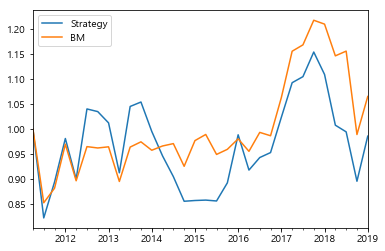

In [48]:
pd.DataFrame({'Strategy':nav, 'BM':nav_bm}).plot()

In [116]:
class Backtest:
    def __init__(self, strat=None, bm=None, fin=None, mc=None):
        self.strat = strat
        self.bm = bm
        self.fin = fin
        self.mc = mc
        
    def run(self):
        dates = self.mc.index[8:]
        positions = {}
        nav = {}
        positions_bm = {}
        nav_bm = {}

        for i,date in enumerate(tqdm_notebook(dates)):
            positions[date] = self.strat(date, fin=fin, mc=mc)
            positions_bm[date] = self.bm(date, fin=fin, mc=mc)

            if i==0:
                nav[date] = 1
                nav_bm[date] = 1

            else:
                date_prev = dates[i-1]
                nav[date] = self._get_nav(nav, positions, date_prev, date)
                nav_bm[date] = self._get_nav(nav_bm, positions_bm, date_prev, date)
                
        self.nav = nav
        self.nav_bm = nav_bm
        self.positions = positions
        self.positions_bm = positions_bm
                
                
    def _get_nav(self, nav, positions, date_prev, date):
        nav_prev = nav[date_prev]
        pos_prev = positions[date_prev]
        assets_prev = pos_prev.index
        pos_update = self.mc.loc[date, assets_prev] / self.mc.loc[date_prev, assets_prev] * pos_prev
        return nav_prev * pos_update.sum()
    
    
    def get_navs(self):
        return pd.DataFrame({'Strategy':self.nav, 'BM':self.nav_bm})
    
    def plot_perf(self):
        self.get_navs().plot()
        
    def stats(self):
        navs = bt.get_navs()
        days_all = (navs.index[-1]-navs.index[0]).days
        ann_rtn = (navs.iloc[-1]**(365/days_all))-1
        return pd.DataFrame({'연수익률':ann_rtn, '변동성':vol, '샤프':ann_rtn/vol})

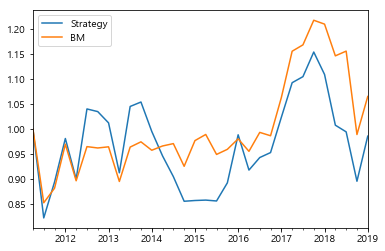

In [66]:
bt = Backtest(strat=매출상위10, bm=BM, fin=fin, mc=mc)
bt.run()
bt.plot_perf()

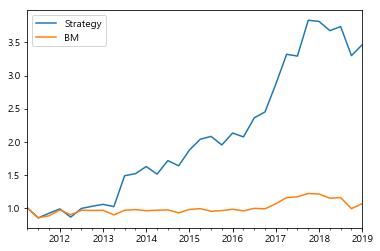

In [117]:
bt = Backtest(strat=시총상위면서저평가, bm=BM, fin=fin, mc=mc)
bt.run()
bt.plot_perf()

In [110]:
bt.stats()

,연수익률,변동성,샤프
Strategy,0.173803,0.234326,0.741717
BM,0.008227,0.121585,0.067661


In [72]:
def 시총상위면서저평가(date, fin=None, mc=None, n=10):
    year = get_year(date)
    marketcap = mc.loc[date].nlargest(200)
    univ = marketcap.index
    bv = fin['자본총계'].xs(year, level=1).loc[univ]
    bp = bv / marketcap
    position = bp.nlargest(n)
    position[:] = 1/len(position)
    return position